In [1]:
import pyrcn

In [2]:
import os

In [3]:
# os.listdir('/Volumes/PassportDrive')

In [3]:
DATA_DIR = 'idrad'
# DATA_DIR = '/Users/davidzhu/Desktop/IDRad/idrad'
DEFAULT_FILE = 'train/target5_001.hdf5'

# Preprocessing

In [4]:
import h5py
import numpy as np 

In [5]:
def range_doppler(data, chirps=256,
                  samples=256,
                  fft_rangesamples=2 ** 10,
                  fft_dopplersamples=2 ** 8,
                  fs=2.0e6,
                  kf=1171875.0e7,
                  min_range=0.5,
                  max_range=10):
    """
    Computes a range-doppler map for a given number of chirps and samples per chirp.
    :param data: FMCW radar data frame consisting of <chirps>x<samples>
    :param chirps: Number of chirps (Np)
    :param samples: Number of samples (N)
    :param fft_rangesamples: Number of samples for the range fft.
    :param fft_dopplersamples: Number of samples for the doppler fft.
    :param fs: Constant depending on the radar recording parameters.
    :param kf: Constant depending on the radar recording parameters.
    :param min_range: Minimum value to take into account for the range axis in the range-doppler map.
    :param max_range: Maximum value to take into account for the range axis in the range-doppler map.
    :return: Returns a 2D dimensional range-doppler map representing the reflected power over all range-doppler bins.
    """

    data = data.reshape(chirps, samples).T
    # Ignore chirp sequence number
    data = data[1:]
    Ny, Nx = data.shape  # rows (N), columns (Np)

    window = np.hanning(Ny)
    scaled = np.sum(window)
    window2d = np.tile(window, (Nx, 1)).T
    data = data * window2d

    # Calculate Range FFT
    x = np.zeros((fft_rangesamples, Nx))
    start_index = int((fft_rangesamples - Ny) / 2)
    x[start_index:start_index + Ny, :] = data
    X = np.fft.fft(x, fft_rangesamples, 0) / scaled * (2.0 / 2048)
    # Extract positive range bins
    X = X[0:fft_rangesamples // 2, :]
    # Extract range
    _freq = np.arange(fft_rangesamples // 2) / float(fft_rangesamples) * fs
    _range = _freq * 3e8 / (2 * kf)
    min_index = np.argmin(np.abs(_range - min_range))
    max_index = np.argmin(np.abs(_range - max_range))

    X = X[min_index: max_index, :]

    # Calculate Doppler FFT
    Ny, Nx = X.shape
    window = np.hanning(Nx)
    scaled = np.sum(window)
    window2d = np.tile(window, (Ny, 1))
    X = X * window2d

    rd = np.zeros((Ny, fft_dopplersamples), dtype='complex_')
    start_index = int((fft_dopplersamples - Nx) / 2)
    rd[:, start_index:start_index + Nx] = X

    range_doppler = np.fft.fft(rd, fft_dopplersamples, 1) / scaled
    range_doppler = np.fft.fftshift(range_doppler, axes=1)

    return np.abs(range_doppler)

def preprocess_file(fname): 
    with h5py.File(f'{DATA_DIR}/{fname}', 'r+') as file:
        nframes = file['radar'].shape[0]

        # Create datasets
        if not 'microdoppler' in file:
            file.create_dataset("microdoppler", (nframes, 256), dtype='float32', chunks=(1, 256))
        if not 'microdoppler_thresholded' in file:
            file.create_dataset("microdoppler_thresholded", (nframes, 256), dtype='float32', chunks=(1, 256))
        if not 'range_doppler' in file:
            file.create_dataset("range_doppler", (nframes, 380, 256), dtype='float32', chunks=True)

        
        x = file['range_doppler'][:10,:,:]
        
        #has not been preprocessed
        if np.all(x==0): 
            print('preprocessing')
        
            # Run over each radar frame
            for i in range(nframes): # only take first 1000 
                rd = range_doppler(file['radar'][i]) 
                rd = 20 * np.log10(rd)

                file['range_doppler'][i] = rd
                file['microdoppler'][i] = rd.sum(axis=0)

                rd -= np.amax(rd)
                rd[rd < -45] = -45
                file['microdoppler_thresholded'][i] = rd.sum(axis=0)

                if not i%100: 
                    print("Finished frame %d of %d." % (i + 1, nframes))
                    
def get_range_doppler(fname): 
    '''returns the range doppler'''
    preprocess_file(fname) 
    range_doppler = 0 
    
    with h5py.File(f'{DATA_DIR}/{fname}', 'r+') as file:
        # d['microdoppler'] = file['microdoppler'][:,:]
        # d['microdoppler_thresholded'] = file['microdoppler_thresholded'][:,:]
        range_doppler = file['range_doppler'][:,:,:].sum(axis=1)
    
    return range_doppler

In [6]:
from copy import deepcopy as copy 

In [7]:
hot_dict = {} 
for i in range(1,6): 
    x = np.zeros(5) 
    x[i-1] = 1 
    hot_dict[i] = x

In [8]:
def load_data(dataset_files, s): 
    dataset = [] 
    labels = []
    labels_hot = [] 
    labels_repeat = [] 
    labels_hot_repeat = [] 

    for fname in dataset_files: 
        if fname[:2] == '._':
            print(fname)
            continue 

        labels.append(int(fname[6]))
        labels_hot.append(copy(hot_dict[labels[-1]]))

        dataset.append(get_range_doppler(f'{s}/{fname}'))

        labels_repeat.append(np.repeat(labels[-1], dataset[-1].shape[0] ))
        labels_hot_repeat.append(np.repeat(labels_hot[-1][np.newaxis, :], dataset[-1].shape[0], axis=0 ))

    # dataset = np.array(dataset) 
    labels = np.array(labels)
    labels_hot = np.array(labels_hot)

    dataset = np.array(dataset, dtype = object)

    labels_repeat = np.array(labels_repeat, dtype = object)
    labels_hot_repeat = np.array(labels_hot_repeat, dtype = object)
    
    labels2, labels_hot2, dataset2, labels_repeat2, labels_hot_repeat2 = np.empty((labels.shape[0]), dtype = object), np.empty((labels.shape[0]), dtype = object), np.empty((labels.shape[0]), dtype = object), np.empty((labels.shape[0]), dtype = object), np.empty((labels.shape[0]), dtype = object)
    
    labels2[:] = list(labels)
    labels_hot2[:] = list(labels_hot)
    dataset2[:] = list(dataset)
    labels_repeat2[:] = list(labels_repeat)
    labels_hot_repeat2[:] = list(labels_hot_repeat)
    
    return labels2, labels_hot2, dataset2, labels_repeat2, labels_hot_repeat2

In [9]:
test_labels, test_labels_hot, test_dataset, test_labels_repeat, test_labels_hot_repeat = load_data(os.listdir(f'{DATA_DIR}/test'), 'test')
for i in range(5): 
    test_dataset[i] = test_dataset[i].astype(np.float32)
    

In [10]:
train_labels, train_labels_hot, train_dataset, train_labels_repeat, train_labels_hot_repeat = load_data(os.listdir(f'{DATA_DIR}/train'), 'train')


In [24]:
valid_labels, valid_labels_hot, valid_dataset, valid_labels_repeat, valid_labels_hot_repeat = load_data(os.listdir(f'{DATA_DIR}/valid'), 'valid')
for i in range(5): 
    valid_dataset[i] = valid_dataset[i].astype(np.float32)


preprocessing
Finished frame 1 of 4507.
Finished frame 101 of 4507.
Finished frame 201 of 4507.
Finished frame 301 of 4507.
Finished frame 401 of 4507.
Finished frame 501 of 4507.
Finished frame 601 of 4507.
Finished frame 701 of 4507.
Finished frame 801 of 4507.
Finished frame 901 of 4507.
Finished frame 1001 of 4507.
Finished frame 1101 of 4507.
Finished frame 1201 of 4507.
Finished frame 1301 of 4507.
Finished frame 1401 of 4507.
Finished frame 1501 of 4507.
Finished frame 1601 of 4507.
Finished frame 1701 of 4507.
Finished frame 1801 of 4507.
Finished frame 1901 of 4507.
Finished frame 2001 of 4507.
Finished frame 2101 of 4507.
Finished frame 2201 of 4507.
Finished frame 2301 of 4507.
Finished frame 2401 of 4507.
Finished frame 2501 of 4507.
Finished frame 2601 of 4507.
Finished frame 2701 of 4507.
Finished frame 2801 of 4507.
Finished frame 2901 of 4507.
Finished frame 3001 of 4507.
Finished frame 3101 of 4507.
Finished frame 3201 of 4507.
Finished frame 3301 of 4507.
Finished fra

# Layer Making

In [11]:
from pyrcn.base.blocks import InputToNode, BatchIntrinsicPlasticity, NodeToNode, HebbianNodeToNode

In [12]:
from pyrcn.echo_state_network import ESNRegressor, ESNClassifier

In [13]:
from pyrcn.base.blocks import InputToNode, PredefinedWeightsInputToNode, NodeToNode
from pyrcn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from pyrcn.model_selection import SequentialSearchCV

from sklearn.base import clone
from sklearn.metrics import make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, ParameterGrid
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils.fixes import loguniform
from sklearn.pipeline import Pipeline
from scipy.stats import uniform

In [69]:
def get_accuracy(model, data, data_labels): 
    predictions = model.predict(data)
    
    correct = []
    for i, prediction in enumerate(predictions):  

        correct.append((prediction == data_labels[i]).mean())

    correct = np.array(correct)
    
    print(correct.mean())
    
    return predictions, correct.mean()

def get_confusion_matrix(true, pred_, num_classes=5): 
    cm = np.zeros((5,5))
    
    for i in range(true.shape[0]): 
        for label, pred in zip(true[i], pred_[i]): 
            cm[label-1, pred-1] += 1 
    
    cm /= cm.sum(axis=1)
    
    return cm

In [89]:
layer_size = 500
bid = True

initial_params = {'hidden_layer_size': layer_size, #1000 in 5C
                  'input_activation': 'tanh', #
                  'k_in' : 1,
                  'bias_scaling': 0.0, # usually 0 
                  'spectral_radius' : 0.0, # 
                  'reservoir_activation': 'tanh', # 2
                  'leakage': 0.05, #equation 6, 17 frames should be 1 step 
                  'bidirectional': True, #bidirectional 
                  'k_rec': layer_size / 10, # optimal is 200 for 1000 layer size 
                  'alpha': 0.1, # figure 6, tuned with k_in
                  'random_state': 1, # 
                  'requires_sequence': True}

In [90]:
i2n = InputToNode(hidden_layer_size=layer_size, input_activation="tanh")

l1 = Pipeline([('i2n', i2n)])
n2n = Pipeline([('layer1', NodeToNode(hidden_layer_size=layer_size, leakage=.05, bidirectional = bid)),
               ('layer2', NodeToNode(hidden_layer_size=layer_size * 2 ** bid, leakage=.05, bidirectional = bid))])
n2o = ESNClassifier(input_to_node=l1, node_to_node=n2n, **initial_params)

n2o.fit(train_dataset, train_labels_repeat)

ESNClassifier(input_to_node=Pipeline(steps=[('i2n', InputToNode())]),
              node_to_node=Pipeline(steps=[('layer1',
                                            NodeToNode(bidirectional=True,
                                                       leakage=0.05)),
                                           ('layer2',
                                            NodeToNode(bidirectional=True,
                                                       hidden_layer_size=1000,
                                                       leakage=0.05))]),
              regressor=IncrementalRegression(alpha=0.1),
              requires_sequence=True)

In [91]:
train_predictions, train_acc = get_accuracy(n2o, train_dataset, train_labels)
test_predictions, test_acc = get_accuracy(n2o, test_dataset, test_labels)
valid_predictions, valid_acc = get_accuracy(n2o, valid_dataset, valid_labels)

0.8901078389849258
0.4833370312846683
0.48440204126913694


[[0.92848904 0.02899235 0.02058746 0.02212436 0.        ]
 [0.00634371 0.96272413 0.02339243 0.00775925 0.        ]
 [0.03208556 0.00786411 0.95236835 0.00723498 0.        ]
 [0.01221558 0.01798259 0.00312252 0.96670861 0.        ]
 [0.         0.         0.         0.01221558 0.98807147]]


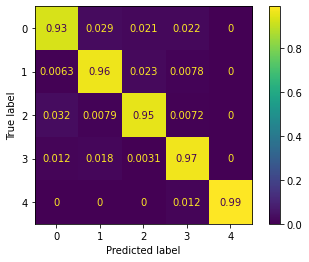

In [79]:
train_cm = get_confusion_matrix(train_labels_repeat, train_predictions)
print(train_cm)

cm_display = ConfusionMatrixDisplay(train_cm, display_labels=[0, 1, 2, 3, 4]).plot()

[[0.         0.69514089 0.16907034 0.         0.13578877]
 [0.         0.99644997 0.         0.         0.00355003]
 [0.         0.20434879 0.69270024 0.09917905 0.00377191]
 [0.         0.         0.         0.         1.        ]
 [0.         0.27246505 0.         0.         0.72753495]]


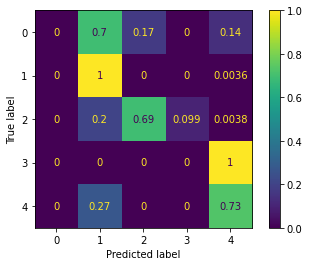

In [80]:
test_cm = get_confusion_matrix(test_labels_repeat, test_predictions)
print(test_cm)

cm_display = ConfusionMatrixDisplay(test_cm, display_labels=[0, 1, 2, 3, 4]).plot()

[[0.05768804 0.35211893 0.         0.27379632 0.31639672]
 [0.         0.96006213 0.00266252 0.03727535 0.        ]
 [0.         0.10539161 0.73885068 0.11692922 0.03882849]
 [0.         0.26935878 0.03106279 0.00177502 0.69780342]
 [0.         0.33192811 0.         0.00443754 0.66363435]]


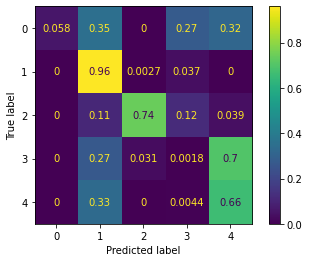

In [81]:
valid_cm = get_confusion_matrix(valid_labels_repeat, valid_predictions)
print(valid_cm)

cm_display = ConfusionMatrixDisplay(valid_cm, display_labels=[0, 1, 2, 3, 4]).plot()

In [ ]:
kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step3 = {'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step4 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}


In [93]:
from sklearn.base import clone
from sklearn.model_selection import ParameterGrid, cross_validate
from sklearn.metrics import make_scorer

from pyrcn.metrics import accuracy_score

In [99]:
def make_classifier(esn_params, bid = True, n2n_leakage = 0.05): 
    i2n = InputToNode(hidden_layer_size=esn_params['hidden_layer_size'], input_activation="tanh")
    
    l1 = Pipeline([('i2n', i2n)])
    
    n2n = Pipeline([('layer1', NodeToNode(hidden_layer_size=esn_params['hidden_layer_size'], leakage= n2n_leakage, bidirectional = bid)),
                   ('layer2', NodeToNode(hidden_layer_size=esn_params['hidden_layer_size'] * 2 ** bid, leakage= n2n_leakage, bidirectional = bid))])
    
    model = ESNClassifier(input_to_node=l1, node_to_node=n2n, **esn_params)
    
    return model

In [ ]:
initial_params = {'input_activation': 'tanh', #
                  'bias_scaling': 0.0, # usually 0 
                  'spectral_radius' : 0.0, # 
                  'reservoir_activation': 'tanh', # 2
                  'leakage': 0.05, #equation 6, 17 frames should be 1 step 
                  'alpha': 0.1, # figure 6, tuned with k_in
                  'random_state': 1, # 
                  'requires_sequence': True}

# test k_rec and k_in

param_grid = {'hidden_layer_size': [250, 500], 
              'k_rec' : [5, 20, 50, 100], 
              'k_in' : [1, 5, 10, 50]}

x = [] 

for i, params in enumerate(ParameterGrid(param_grid)):
    for k, v in params.items(): 
        initial_params[k] = v
        
    model = make_classifier(initial_params)
    
    model.fit(train_dataset, train_labels_repeat)
    
    valid_predictions, valid_acc = get_accuracy(model, valid_dataset, valid_labels)
    
    print(valid_acc)
    
    x.append((valid_acc, param_grid))


0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323
0.24175726647437323


In [ ]:
# model from door example



initially_fixed_params = {'hidden_layer_size': 100,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 0.0,
                          'leakage': 0.1,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bidirectional': False,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-3,
                          'random_state': 42}

step1_esn_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                    'spectral_radius': uniform(loc=0, scale=2)}

step2_esn_params = {'leakage': loguniform(1e-5, 1e0)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}
step4_esn_params = {'alpha': loguniform(1e-5, 1e1)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step3 = {'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step4 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', RandomizedSearchCV, step1_esn_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step2),
            ('step3', GridSearchCV, step3_esn_params, kwargs_step3),
            ('step4', RandomizedSearchCV, step4_esn_params, kwargs_step4)]

base_km_esn = ESNClassifier(input_to_node=PredefinedWeightsInputToNode(predefined_input_weights=w_in.T),
                                    **initially_fixed_params)

try:
    sequential_search = load("RICSyN2015/sequential_search_RICSyN2015_km_large_1.joblib")
except FileNotFoundError:
    sequential_search = SequentialSearchCV(base_km_esn, searches=searches).fit(dataset, labels_repeat)
    dump(sequential_search, "RICSyN2015/sequential_search_RICSyN2015_km_large_1.joblib")

In [ ]:
base_esn.fit(dataset, labels_repeat)

In [ ]:
predictions = base_esn.predict(dataset)

In [ ]:
correct = []
for i, prediction in enumerate(predictions):  
    
    correct.append((prediction == labels[i]).mean())

correct = np.array(correct)

In [ ]:
correct.mean()

In [ ]:
correct